In [1]:
import numpy as np
import numpy.linalg as npla
import scipy.linalg as spla
import scipy.stats as st
import math
import sympy as smp
import random as rd
import matplotlib.pyplot as plt

In [2]:
class def_episode:
    def __init__(self, evnts, edge_set):
        self.freq = 0
        self.evnts = evnts.copy()
        self.edges = edge_set.copy()

class def_NFA:
    def __init__(self):
        self.s = set()
        self.S = list([self.s])
        self.F = -1
        self.D = {}

class def_DFA:
    def __init__(self):
        self.s = {0}
        self.S = list([self.s])
        self.F = list()
        self.D = {}

In [3]:
def Construct_NFA(alpha):
    alpha_size = len(alpha.evnts)
    pi = {}
    for e in alpha.evnts:
        pi[e] = set()
    for (e1,e2) in alpha.edges:
        pi[e2].add(e1)
    NFA = def_NFA()
    n_states = 1
    for Q in NFA.S:
        NFA.D[str(Q)] = {}
        if len(Q) != alpha_size:
            for ev in alpha.evnts-Q:
                if not (alpha.evnts-Q).intersection(pi[ev]):
                    Q_new = Q.copy()
                    Q_new.add(ev)
                    if Q_new in NFA.S:
                        NFA.D[str(Q)][ev] = {NFA.S.index(Q_new)}
                    else:
                        NFA.S.append(Q_new)
                        NFA.D[str(Q)][ev] = {len(NFA.S)-1}
            NFA.D[str(Q)]['def'] = {NFA.S.index(Q)}
        else:
            NFA.D[str(Q)]['def'] = set()
            NFA.F = NFA.S.index(Q)
    for ev in alpha.evnts:
        if not alpha.evnts.intersection(pi[ev]):
            NFA.D[str(NFA.s)][ev].add(0)
    return NFA

In [4]:
def Construct_DFA(NFA):
    DFA = def_DFA()
    for state in DFA.S:
        if (NFA.F in state):
            DFA.F.append(state)
        DFA.D[str(state)] = {}
        W = set({})
        for substate in state:
            Q = str(NFA.S[substate])
            W = W.union(set(NFA.D[Q].keys()))
        for ev in W:
            new_state = set()
            for substate in state:
                Q = str(NFA.S[substate])
                if ev in NFA.D[Q].keys():
                    new_state = new_state.union(NFA.D[Q][ev])
                else:
                    new_state = new_state.union(NFA.D[Q]['def'])
            DFA.D[str(state)][ev] = new_state.copy()
            if new_state not in DFA.S:
                        DFA.S.append(new_state)
        keys = list(DFA.D[str(state)].keys())
        for k in range(len(keys)):
            if keys[k] != 'def' and DFA.D[str(state)][keys[k]] == DFA.D[str(state)]['def']:
                del DFA.D[str(state)][keys[k]]
            else:
                k += 1
    return DFA

In [5]:
def GetTransitionMatrix(DFA,prob):
    T0 = list()
    for state in DFA.S:
        T0.append([0]*len(DFA.S))
        for ev in DFA.D[str(state)].keys():
            if ev == 'def':
                continue
            T0[-1][DFA.S.index(DFA.D[str(state)][ev])] += prob[ev]
        T0[-1][DFA.S.index(DFA.D[str(state)]['def'])] = round(1 - sum(T0[-1]),5)
    return(T0)

In [6]:
def GetStats(T0,final_states):

    ndiags = len(T0)
    nfinals = len(final_states)
    
    if nfinals == 0:
        return(0,0)
    
    T = np.matrix(T0)
    L = np.eye(ndiags)

    dQdu = 0
    d2Qdu2 = 0
    for k1 in range(nfinals):
        L1 = L.copy()
        L1[final_states[k1],final_states[k1]] = 0
        dQdu += spla.det(L1-T)
        for k2 in range(k1+1,nfinals):
            L2 = L1.copy()
            L2[final_states[k2],final_states[k2]] = 0
            d2Qdu2 += spla.det(L2-T)
    d2Qdu2 *= 2

    dQdl = 0
    d2Qdl2 = 0
    d2Qdudl = 0
    for k1 in range(ndiags):
        T1 = T.copy()
        T1[:,k1] *= 0
        dQdl += spla.det(L-T1)
        for f1 in final_states:
            if k1 != f1:
                L1 = L.copy()
                L1[f1,f1] = 0
                d2Qdudl += spla.det(L1-T1)
        for k2 in range(k1+1,ndiags):
            T2 = T1.copy()
            T2[:,k2] *= 0
            d2Qdl2 += spla.det(L-T2)
    d2Qdl2 *= 2


    lambda1 = -dQdu/dQdl
    lambda11 = -(d2Qdu2 + 2*lambda1*d2Qdudl + lambda1**2*d2Qdl2)/dQdl

    MX1 = lambda1
    VX1 = lambda11 + lambda1 - lambda1**2

    return MX1, VX1


# def GetStats(T0,final_states):

#     u = smp.symbols('u')
#     Dphi = smp.eye(len(T0))
#     for final in final_states:
#         Dphi[final,final] = u

#     Tu = smp.Matrix(T0)*Dphi
#     lamda = smp.symbols('lambda')
#     lTu = lamda*smp.eye(len(T0))-Tu
    
#     Qn = 1
#     for dia in range(len(T0)):
#         Qn *= lTu[dia,dia]
#         for row in range(dia+1,len(T0)):
#             if lTu[row,dia] != 0:
#                 coeff = lTu[row,dia]/lTu[dia,dia]
#                 for col in range(dia,len(T0)):
#                     if lTu[dia,col] != 0:
#                         lTu[row,col] = lTu[row,col]-lTu[dia,col]*coeff

#     dQdu_exp = smp.diff(Qn,u)
#     dQdu = dQdu_exp.subs([(u,1),(lamda,1)])
#     dQdl_exp = smp.diff(Qn,lamda).subs([(u,1)])
#     dQdl = dQdl_exp.subs([(u,1),(lamda,1)])
#     d2Qdu2 = smp.diff(dQdu_exp,u).subs([(u,1),(lamda,1)])
#     d2Qdl2 = smp.diff(dQdl_exp,lamda).subs([(lamda,1)])
#     d2Qdudl = smp.diff(dQdu_exp,lamda).subs([(u,1),(lamda,1)])

#     lambda1 = -dQdu/dQdl
#     lambda11 = -(d2Qdu2 + 2*lambda1*d2Qdudl + lambda1**2*d2Qdl2)/dQdl

#     MX1 = lambda1
#     VX1 = lambda11 + lambda1 - lambda1**2
    
#     return(MX1, VX1)

In [7]:
global final_states, T0, alphabet

M = 30
alphabet = ['A','B','C','D','E','F','G','H','I','J']#,'K','L','M','N','O','P','Q','R','S','T']
alphabet_length = len(alphabet)
for k in range(M-alphabet_length):
    alphabet.append(str(k))
M = len(alphabet)

specs = 'dense'


# General Injective episodes

Ep_Events = []
episodes = []
structure = []

# Ep_Events.append(list(['A','B']))
# episodes.append(list([]))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','B')})))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({})))
# structure.append([])
# structure[-1].append('A-B')
# structure[-1].append('(AB)')


Ep_Events.append(list(['A','B','C']))
episodes.append(list([]))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','B'),('A','C'),('B','C')})))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','C'),('B','C')})))
episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','B'),('A','C')})))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({})))
structure.append([])
# structure[-1].append('A-B-C')
# structure[-1].append('(AB)-C')
structure[-1].append('A-(BC)')
# structure[-1].append('(ABC)')


Ep_Events.append(list(['A','B','C','D']))
episodes.append(list([]))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','B'),('A','C'),('A','D'),('B','C'),('B','D'),('C','D')})))
episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','B'),('A','C'),('A','D'),('B','D'),('C','D')})))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','D'),('B','D'),('C','D')})))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','C'),('A','D'),('B','C'),('B','D')})))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','B'),('A','C'),('A','D')})))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({})))
structure.append([])
# structure[-1].append('A-B-C-D')
structure[-1].append('A-(BC)-D')
# structure[-1].append('(ABC)-D')
# structure[-1].append('(AB)-(CD)')
# structure[-1].append('A-(BCD)')
# structure[-1].append('(ABCD)')


Ep_Events.append(list(['A','B','C','D','E']))
episodes.append(list([]))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','B'),('A','C'),('A','D'),('A','E'),('B','C'),('B','D'),('B','E'),('C','D'),('C','E'),('D','E')})))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','C'),('A','D'),('A','E'),('B','C'),('B','D'),('B','E'),('C','E'),('D','E')})))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','B'),('A','C'),('A','D'),('A','E'),('B','E'),('C','E'),('D','E')})))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','E'),('B','E'),('C','E'),('D','E')})))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','B'),('A','C'),('A','D'),('A','E'),('B','D'),('B','E'),('C','D'),('C','E')})))
episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','C'),('A','D'),('A','E'),('B','C'),('B','D'),('B','E'),('C','D'),('C','E')})))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','C'),('A','D'),('A','E'),('B','C'),('B','D'),('B','E')})))
episodes[-1].append(def_episode(set(Ep_Events[-1]),set({})))
structure.append([])
# structure[-1].append('A-B-C-D-E')
# structure[-1].append('(AB)-(CD)-E')
# structure[-1].append('A-(BCD)-E')
# structure[-1].append('(ABCD)-E')
# structure[-1].append('A-(BC)-(DE)')
structure[-1].append('(AB)-C-(DE)')
# structure[-1].append('(AB)-(CDE)')
structure[-1].append('(ABCDE)')


Ep_Events.append(list(['A','B','C','D','E','F']))
episodes.append(list([]))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','B'),('A','C'),('A','D'),('A','E'),('A','F'),('B','C'),('B','D'),('B','E'),('B','F'),('C','D'),('C','E'),('C','F'),('D','E'),('D','F'),('E','F')})))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','B'),('A','C'),('A','D'),('A','E'),('A','F'),('B','D'),('B','E'),('B','F'),('C','D'),('C','E'),('C','F'),('D','F'),('E','F')})))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','C'),('A','D'),('A','E'),('A','F'),('B','C'),('B','D'),('B','E'),('B','F'),('C','F'),('D','F'),('E','F')})))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','B'),('A','C'),('A','D'),('A','E'),('A','F'),('B','F'),('C','F'),('D','F'),('E','F')})))
episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','C'),('A','D'),('A','E'),('A','F'),('B','C'),('B','D'),('B','E'),('B','F'),('C','D'),('C','E'),('C','F'),('D','E'),('D','F'),})))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','C'),('A','D'),('A','E'),('A','F'),('B','C'),('B','D'),('B','E'),('B','F'),('C','E'),('C','F'),('D','E'),('D','F')})))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','D'),('A','E'),('A','F'),('B','D'),('B','E'),('B','F'),('C','D'),('C','E'),('C','F')})))
episodes[-1].append(def_episode(set(Ep_Events[-1]),set({('A','B'),('A','C'),('A','D'),('A','E'),('A','F'),('B','C'),('B','D'),('E','F')})))
# episodes[-1].append(def_episode(set(Ep_Events[-1]),set({})))
structure.append([])
# structure[-1].append('A-B-C-D-E-F')
# structure[-1].append('A-(BC)-(DE)-F')
# structure[-1].append('(AB)-(CDE)-F')
# structure[-1].append('A-(BCDE)-F')
structure[-1].append('(AB)-C-D-(EF)')
# structure[-1].append('(AB)-(CD)-(EF)')
# structure[-1].append('(ABC)-(DEF)')
structure[-1].append('A-((B-(CD))(E-F))')
# structure[-1].append('(ABCDEF)')

info  = ''
for ep_grp in range(len(episodes)):
    for ep_id in range(len(episodes[ep_grp])):
        info += 'Episode: '+ structure[ep_grp][ep_id] +'\n'
        info += 'Events: ' + str(episodes[ep_grp][ep_id].evnts) + '\n'
        info += 'Edges: ' + str(episodes[ep_grp][ep_id].edges) + '\n\n'

print('List of episodes: \n')
print(info)


List of episodes: 

Episode: A-(BC)
Events: {'B', 'A', 'C'}
Edges: {('A', 'B'), ('A', 'C')}

Episode: A-(BC)-D
Events: {'D', 'B', 'A', 'C'}
Edges: {('A', 'B'), ('A', 'D'), ('A', 'C'), ('B', 'D'), ('C', 'D')}

Episode: (AB)-C-(DE)
Events: {'B', 'E', 'A', 'C', 'D'}
Edges: {('A', 'D'), ('A', 'E'), ('B', 'D'), ('B', 'E'), ('C', 'D'), ('C', 'E'), ('A', 'C'), ('B', 'C')}

Episode: (ABCDE)
Events: {'B', 'E', 'A', 'C', 'D'}
Edges: set()

Episode: (AB)-C-D-(EF)
Events: {'B', 'E', 'A', 'C', 'D', 'F'}
Edges: {('A', 'D'), ('A', 'E'), ('B', 'D'), ('B', 'E'), ('C', 'D'), ('C', 'E'), ('D', 'F'), ('A', 'F'), ('D', 'E'), ('A', 'C'), ('B', 'F'), ('C', 'F'), ('B', 'C')}

Episode: A-((B-(CD))(E-F))
Events: {'B', 'E', 'A', 'C', 'D', 'F'}
Edges: {('A', 'D'), ('A', 'E'), ('B', 'D'), ('E', 'F'), ('A', 'B'), ('A', 'F'), ('A', 'C'), ('B', 'C')}




Episode:  A-(BC)
Events:  {'B', 'A', 'C'}
Edges:  {('A', 'B'), ('A', 'C')}
no of states:  9
no of final states:  3
0.0018903175606089638 0.0017069137660005952


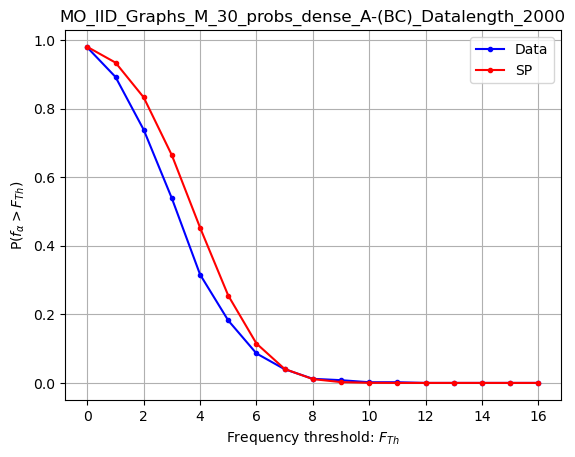

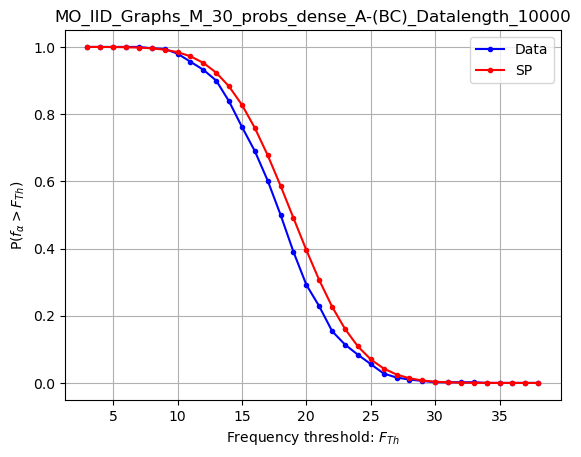

Episode:  A-(BC)-D
Events:  {'D', 'B', 'A', 'C'}
Edges:  {('A', 'B'), ('A', 'D'), ('A', 'C'), ('B', 'D'), ('C', 'D')}
no of states:  18
no of final states:  6
0.0018248875510388487 0.001538074500791054


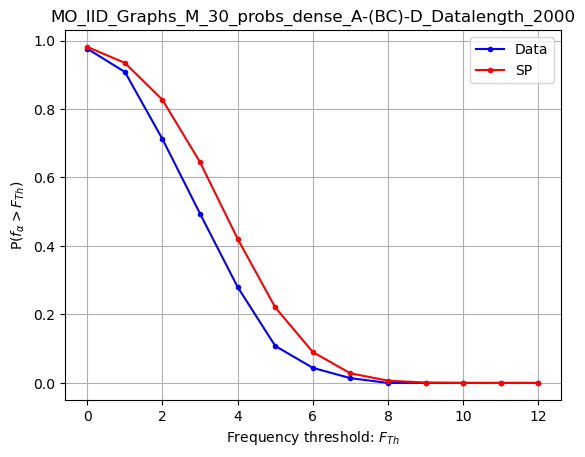

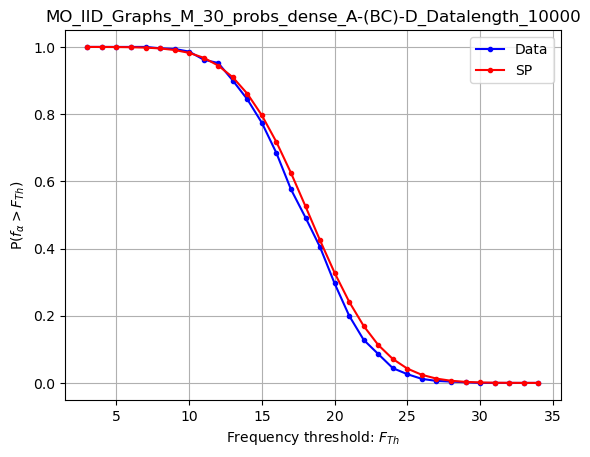

Episode:  (AB)-C-(DE)
Events:  {'B', 'E', 'A', 'C', 'D'}
Edges:  {('A', 'D'), ('A', 'E'), ('B', 'D'), ('B', 'E'), ('C', 'D'), ('C', 'E'), ('A', 'C'), ('B', 'C')}
no of states:  37
no of final states:  12
0.002491462069664939 0.0031248483804351287


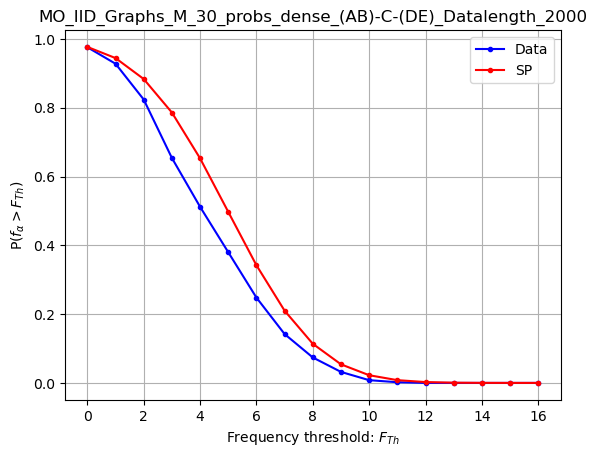

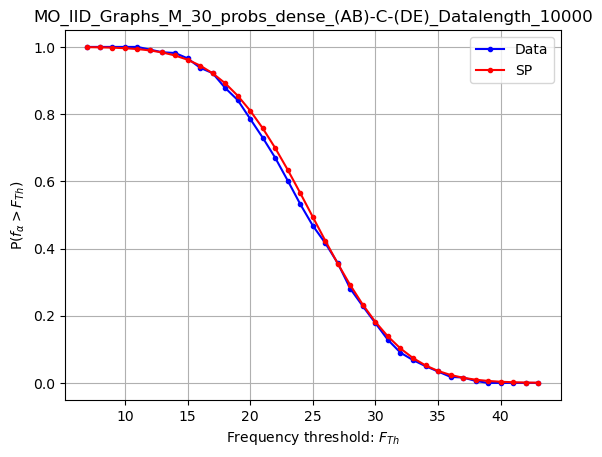

Episode:  (ABCDE)
Events:  {'B', 'E', 'A', 'C', 'D'}
Edges:  set()
no of states:  326
no of final states:  120
0.005619102652056141 0.015609223765639352


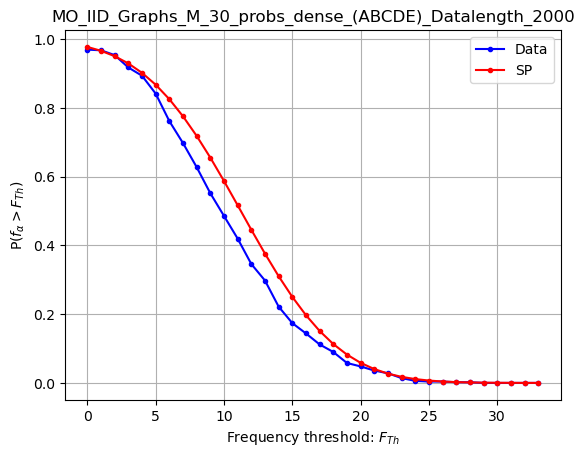

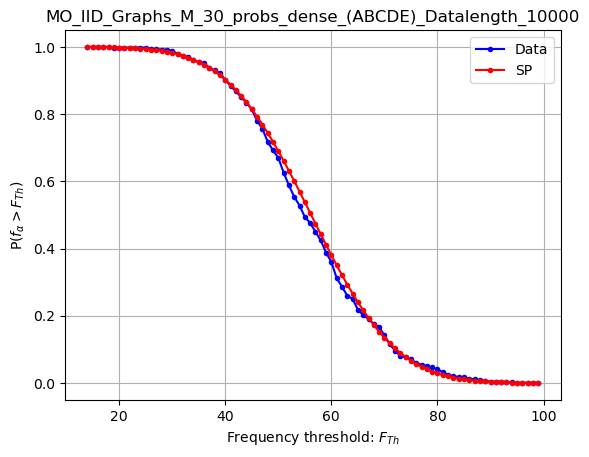

Episode:  (AB)-C-D-(EF)
Events:  {'B', 'E', 'A', 'C', 'D', 'F'}
Edges:  {('A', 'D'), ('A', 'E'), ('B', 'D'), ('B', 'E'), ('C', 'D'), ('C', 'E'), ('D', 'F'), ('A', 'F'), ('D', 'E'), ('A', 'C'), ('B', 'F'), ('C', 'F'), ('B', 'C')}
no of states:  73
no of final states:  24
0.0019994464542048705 0.0019101850589611827


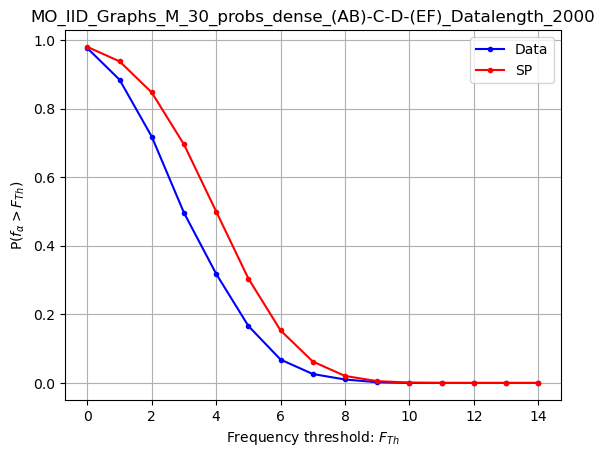

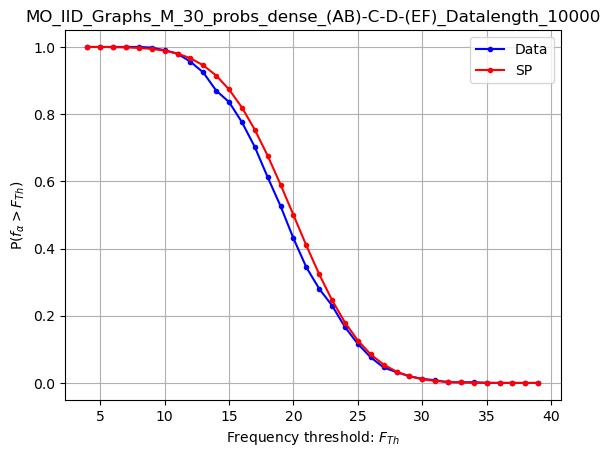

Episode:  A-((B-(CD))(E-F))
Events:  {'B', 'E', 'A', 'C', 'D', 'F'}
Edges:  {('A', 'D'), ('A', 'E'), ('B', 'D'), ('E', 'F'), ('A', 'B'), ('A', 'F'), ('A', 'C'), ('B', 'C')}
no of states:  378
no of final states:  126
0.001738643041652353 0.0013618086852823159


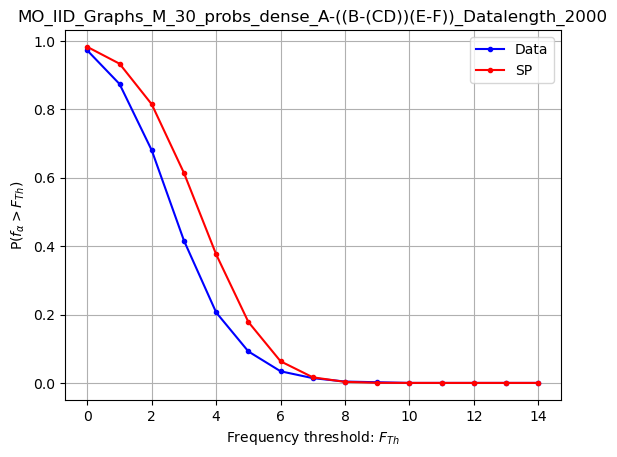

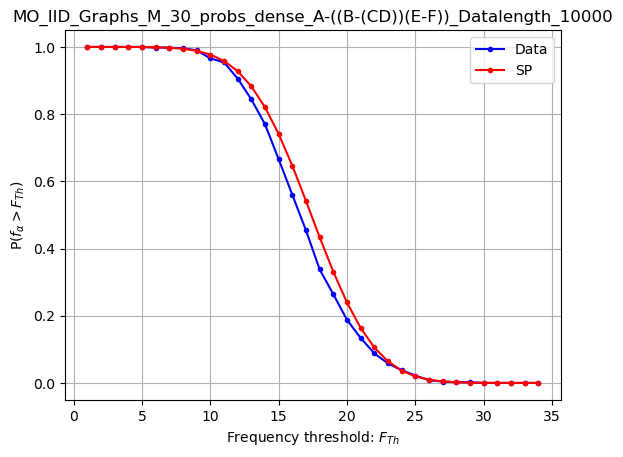

In [8]:
Prob_Ep_Events = {}
saved_probs = np.load('IID_M_'+str(M)+'_probs_'+str(specs)+'.npy')
for k in range(len(alphabet)):
    Prob_Ep_Events[alphabet[k]] = saved_probs[k]



for ep_grp in range(len(episodes)):
    for ep_id in range(len(episodes[ep_grp])):
        
        NFA = Construct_NFA(episodes[ep_grp][ep_id])
        DFA = Construct_DFA(NFA)
        
        final_states = list()
        for k in range(len(DFA.S)):
            if (NFA.F in DFA.S[k]):
                final_states.append(k)
                
        T0 = GetTransitionMatrix(DFA,Prob_Ep_Events)
        
        print('Episode: ', structure[ep_grp][ep_id])
        print('Events: ', episodes[ep_grp][ep_id].evnts)
        print('Edges: ', episodes[ep_grp][ep_id].edges)
        print('no of states: ', len(DFA.S))
        print('no of final states: ', len(DFA.F))
        
        
        MX_SP, VX_SP = GetStats(T0, final_states)
        print(MX_SP, VX_SP)
        
        T_list = [2000, 10000]
        runs = 500
        for T in T_list:
            freq_list = list([])
            states = range(len(T0[0]))
            for run in range(runs):
                curr_state = [0]
                ep_freq = 0
                for ti in range(T):
                    curr_state = rd.choices(states, T0[curr_state[0]], k=1)
                    if curr_state[0] in final_states:
                        ep_freq += 1
                freq_list.append(ep_freq)
            freq_list.sort()
            fmax = max(freq_list)
            fmin = min(freq_list)

            
            x_vals = range(max(0,fmin-5),fmax+5)
            
            graph0 = list([])
            for kkk in x_vals:
                graph0.append(0)
                for freq in freq_list:
                    if freq > kkk:
                        graph0[-1] += 1
                graph0[-1] /= runs

            graph1 = list([])
            for kkk in x_vals:
                graph1.append(1-st.norm(loc = T*MX_SP , scale = math.sqrt(T*VX_SP)).cdf(kkk))
            
            x_vals = range(max(0,fmin-5),fmax+5)
            plt.plot(x_vals, graph0, '.-b')
            plt.plot(x_vals, graph1, '.-r')
            plt.xlabel('Frequency threshold: $F_{Th}$')
            plt.ylabel(r'P$( f_\alpha > F_{Th} )$')
            plt.legend(['Data','SP'])
            plt.title('MO_IID_Graphs_M_'+str(M)+'_probs_'+str(specs)+'_'+structure[ep_grp][ep_id]+'_Datalength_' + str(T))
            plt.grid()
            plt.show()